In [45]:
import sys
from pathlib import Path


NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parents[0]

sys.path.append(str(PROJECT_ROOT))

print("notebook direction:", NOTEBOOK_DIR)
print("project directions:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / 'src').exists())

notebook direction: /Users/naorsaati/Desktop/eltaProject/notebooks
project directions: /Users/naorsaati/Desktop/eltaProject
src exists: True


In [46]:
from src.data import download_titanic_dataset
download_titanic_dataset(force=False)

Titanic dataset already exists in data/raw. Skipping download.


In [47]:
from src.data import load_titanic_raw
train_df, test_df, gender_df = load_titanic_raw()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Pclass.mean = 2.3

Pclass,std = 0.83 (relatively low)

Possible values: 1–3

No outliers

Pclass is probably a significant factor — Class 1 = wealthier -> accessibility to lifeboats -> higher survivability.


survived.mean = 38%

There is an imbalance, so accuracy alone is not good enough to measure performance and it is important to also look at precision/recall.

There are a lot of missing values ​​in "cabin" - i chose to remove it, because over 77% missing values, meaning the fitter is unstable.

There are about 20% missing values ​​in "age" - this data is very important for prediction, so i chose to handle it by filling it using median according group,
Sex × Pclass, because the age is not distributed equally across each group of passengers.

There are only 2 missing values ​​in "embarked" - we'll fill them in with the most common value - it won't make a lot of noise.

In [50]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

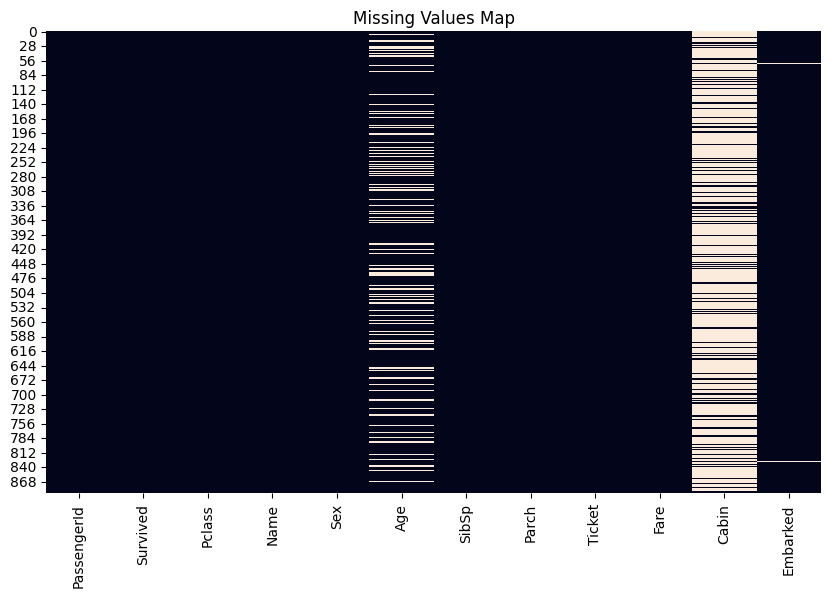

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(train_df.isna(), cbar=False)
plt.title("Missing Values Map")
plt.show()

In the graph, you can see that the dominant class is 0 (did not survive) and only about 38% of the samples are 1 (survived).

That is, there is an "imbalance" in the classes (class imbalance) – most passengers did not survive.

a model that always guesses “did not survive” will have reasonable accuracy, so it is important to look at Precision/Recall and not just Accuracy.

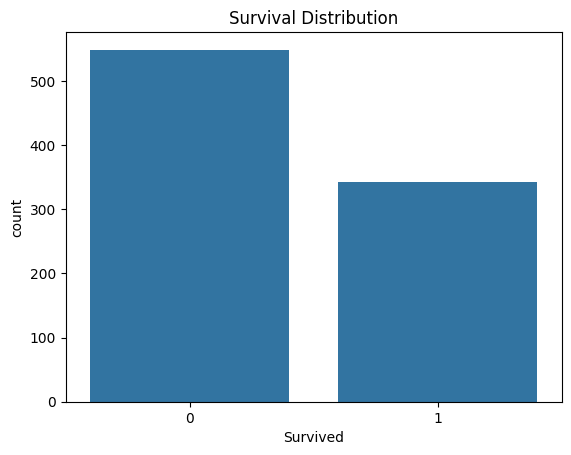

In [52]:
sns.countplot(x=train_df["Survived"])
plt.title("Survival Distribution")
plt.show()

The age distribution seems roughly normal around 20–30.

Age is a very important feature because children vs. adults may be given priority in lifeboats

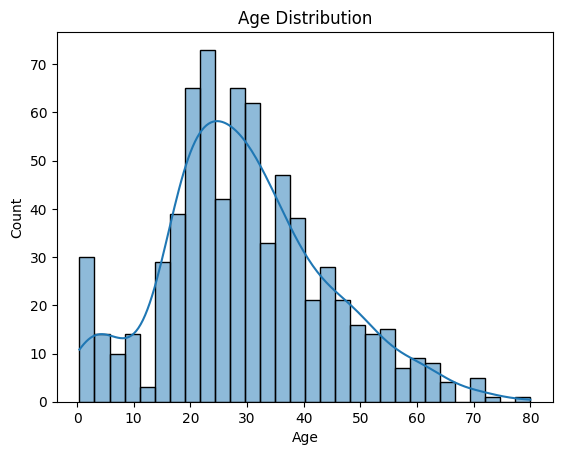

In [53]:
plt.figure()
sns.histplot(data=train_df, x="Age", bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

The Fare distribution is very skewed: most passengers paid a relatively low price, but there is a very long tail with very high ticket prices, which suggests outliners.

In addition, very high values ​​-> we will have to normalize them.

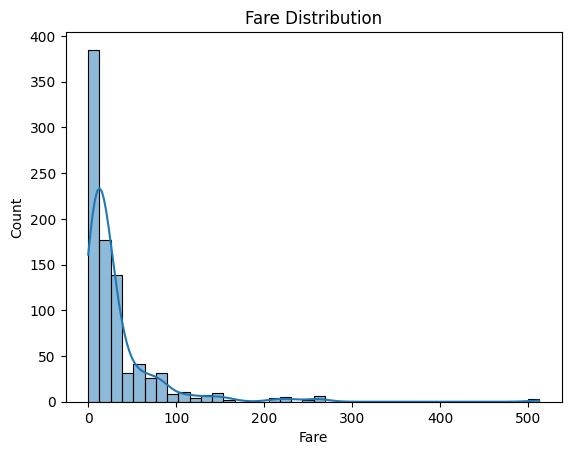

In [54]:
plt.figure()
sns.histplot(data=train_df, x="Fare", bins=40, kde=True)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Count")
plt.show()

Women survived at a much higher rate than men, perhaps because they gave women priority.

This is important feature.

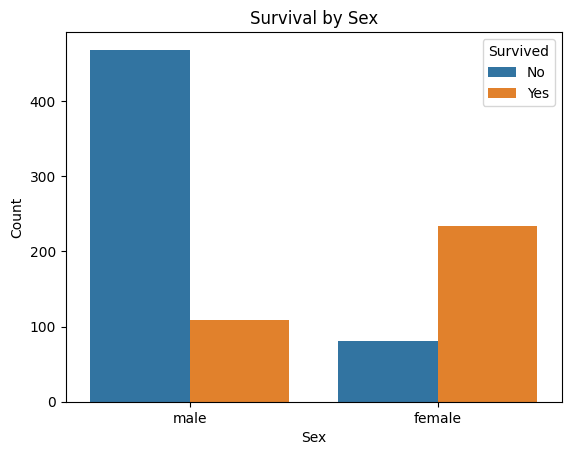

In [55]:
plt.figure()
sns.countplot(data=train_df, x="Sex", hue="Survived")
plt.title("Survival by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

I see that Class 1 enjoys a significantly higher survival rate compared to Class 3.

In Class 2, almost half survived and half did not.

This suggests that economic status/position on the ship greatly influenced the chances of reaching the lifeboats.

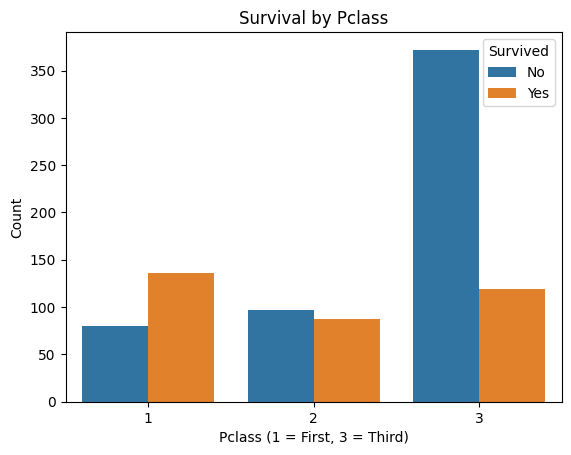

In [56]:
plt.figure()
sns.countplot(data=train_df, x="Pclass", hue="Survived")
plt.title("Survival by Pclass")
plt.xlabel("Pclass (1 = First, 3 = Third)")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

Some differences are seen in survival rates between the different ants (C, Q, S).

The effect is less strong than Sex or Pclass, but it still exists.

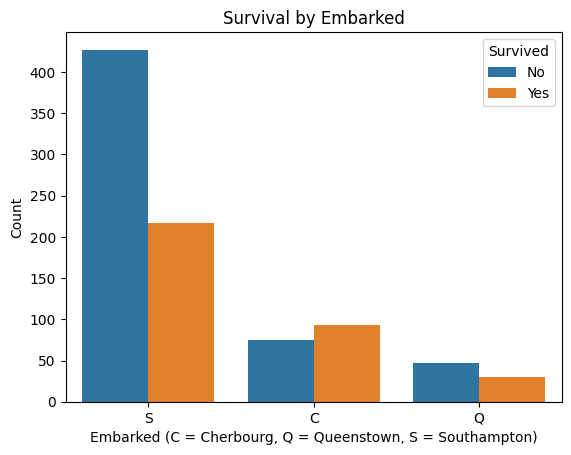

In [57]:
plt.figure()
sns.countplot(data=train_df, x="Embarked", hue="Survived")
plt.title("Survival by Embarked")
plt.xlabel("Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()


Conclusions from the correlation map:

1) "Survived" has a relatively strong negative correlation with "Pclass" (the lower the class, the less likely to survive).

2) "Survived" positively correlated with "Sex" (after coding male=1, female=0).

3) There is a certain positive correlation between "Fare" and "Survived" (the more you paid, the more likely you were in a good class and survived).

4) The most powerful features for the model are: Sex, Pclass, Age, Fare. The rest also contribute but weakly.

/var/folders/n2/5zs6svl55gx64b0r2s5n0yn80000gn/T/ipykernel_76499/316950301.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["Sex"] = train_df["Sex"].replace({"male": 1, "female": 0})
/var/folders/n2/5zs6svl55gx64b0r2s5n0yn80000gn/T/ipykernel_76499/316950301.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["Embarked"] = train_df["Embarked"].replace({"S": 0, "C": 1, "Q": 2})


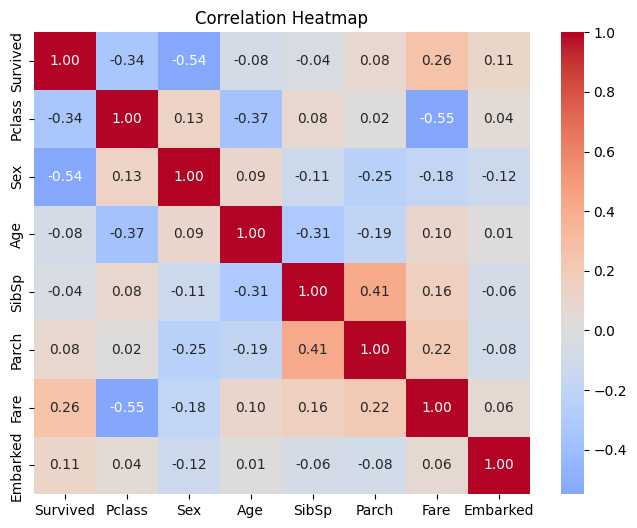

In [58]:
train_df = train_df.copy()

train_df["Sex"] = train_df["Sex"].replace({"male": 1, "female": 0})
train_df["Embarked"] = train_df["Embarked"].replace({"S": 0, "C": 1, "Q": 2})

plt.figure(figsize=(8, 6))

# בוחר רק עמודות מספריות רלוונטיות
corr_cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
corr = train_df[corr_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()
